In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

%load_ext autoreload

In [1]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad


import optax
import torch.utils.data as data
from flax import linen as nn

from functools import partial
import itertools
from tqdm.auto import trange
import matplotlib.pyplot as plt

import pickle

from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)

In [2]:
#### Preparing data
data_dict = pickle.load(open('model_data_dictionary_N_Pa.pkl', 'rb'))


# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

print("After grouping all data together, relevant shapes are:")
print(f"us : {us.shape}")
print(f"ys : {ys.shape}")
print(f"fs : {fs.shape}")
print(f"ws : {ws.shape}")

In total there are 22 distinct membranes.
After grouping all data together, relevant shapes are:
us : (188318, 7)
ys : (188318, 1)
fs : (188318, 1)
ws : (188318, 1)


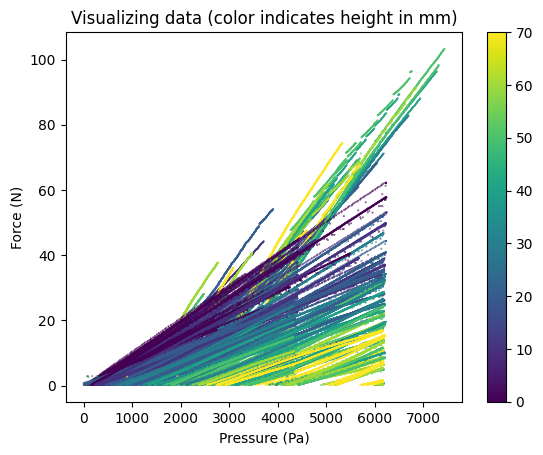

In [3]:
hs = us[:,0]
plt.scatter(ys, fs, c=hs, s=0.1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Force (N)')
plt.colorbar()
plt.title("Visualizing data (color indicates height in mm)")
plt.show()

## Training Model from Data

In [9]:
from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

In [11]:
# define architecture
ensemble_size = 32
ring_encoder = RingEncoding(24, identity)
latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
arch = MonotonicActuator(
# arch = Actuator(
    ring_encoder,
    latent_encoder,
    polynomial_degree=1,
    output_activation=nn.leaky_relu,
)
ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

In [12]:
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))

# Define ensemble
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1., key=random.key(24)) #start model
print(model.tabulate())

Initializing model...

                                             RPNEnsemble Summary                                              
┌──────────────────────┬───────────────────┬────────────────────┬─────────────────────┬──────────────────────┐
│ path                 │ module            │ inputs             │ outputs             │ params               │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│                      │ RPNEnsemble       │ - float32[10000,7] │ float32[32,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │                      │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ OperatorEnsemble_0   │ OperatorEnsemble  │ - float32[10000,7] │ float32[64,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │  

In [13]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

100%|██████████| 10000/10000 [21:15<00:00,  7.84it/s, loss=0.80881566, grad_norm=0.46582568]


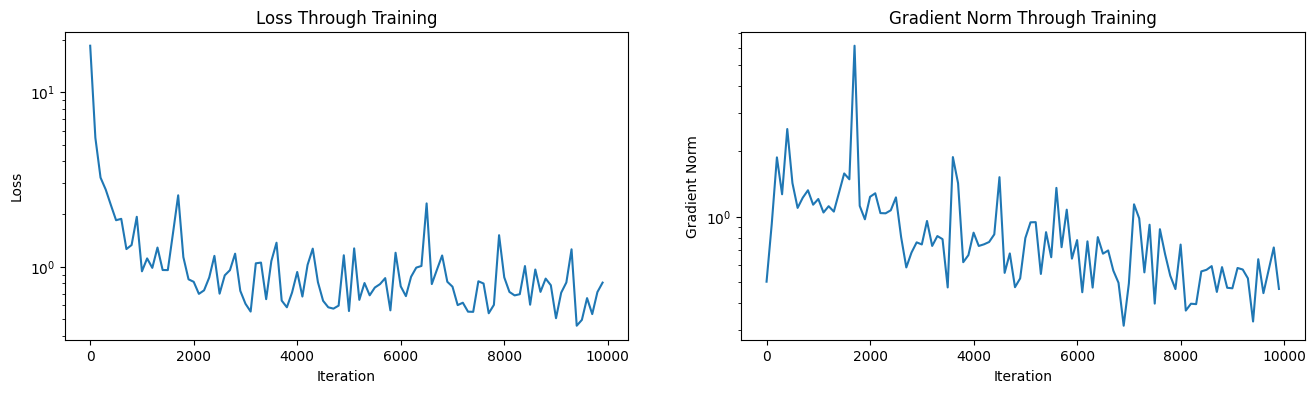

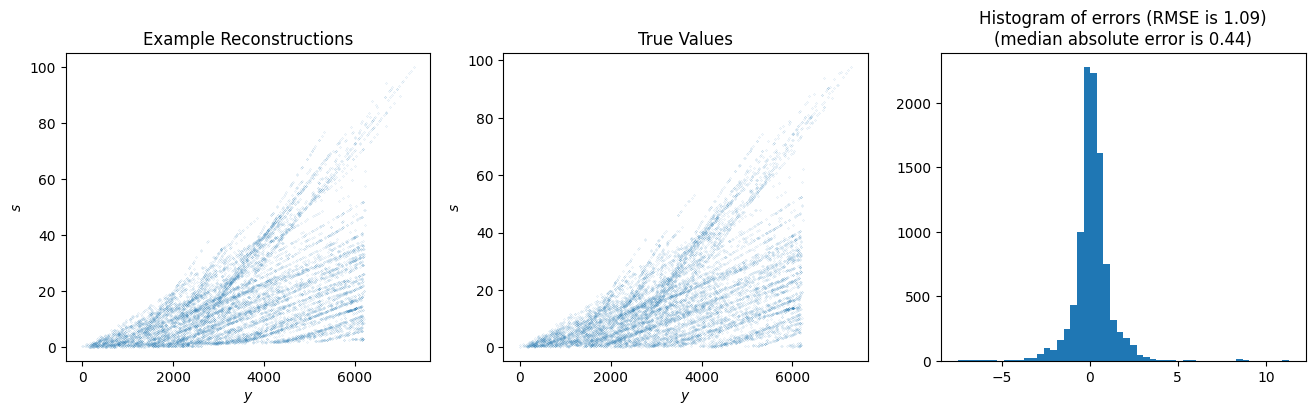

In [14]:
# display training logs
model.plot_training_log()
model.plot_predictions(init_batch)

## Membrane Design Optimization

In [27]:
%load_ext autoreload
%autoreload 2
from acquisition import MCAcquisition
from design_optimization import get_trajectory_posterior_fn, get_height_max_posterior_fn
from design_optimization import opt_var_to_phys_var, print_recommendations

#### Optimization 1 - Relevant to Membrane 6

In [28]:
# set target Forces and Pressures (they should be the same shape)
target_Fs = jnp.array([24.5, 24.5, 24.5])
target_Ps = jnp.array([4137, 5516, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)

In [29]:
q = 1 # number of membranes to return
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
# solve a 2-ringed membrane
for num_rings in [2]:
    # that maximizes height for target F and P
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [05:41<00:00, 14.65it/s]


In [30]:
# display best membrane outcome with acquisition score
for num_rings in [2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[0] : .2e}):')

    membrane_coef = opt_var_to_phys_var(recs[0][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)


------------------

Using 2 rings (acquisition score is -4.01e-01):

Membrane:
thickness:  2.00
contact radius:  25.40
Ring 1) radius:  33.40; width:  5.00
Ring 2) radius:  46.40; width:  5.00


#### 2nd Design Optimization (go to high force high pressure) - relevant to membrane 7

In [31]:
# set target Forces and Pressures (they should be the same shape)
target_Fs = jnp.array([14.7, 24.5, 39.24])
target_Ps = jnp.array([8273, 8273, 8273])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [32]:
q = 1 # number of membranes to return
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
# solve a 2-ring membrane
for num_rings in [2]:
    # that maximizes height for target F and P
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [06:22<00:00, 13.08it/s]


In [35]:
# display best membrane outcome with acquisition score
for num_rings in [2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[0] : .2e}):')

    membrane_coef = opt_var_to_phys_var(recs[0][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

# NOTE - these outcomes are slightly different than the membrane that was fabricated for the paper.
# They were very sensitive to hyperparameters and have varied across minima as the model has evolved.
# We expect this membrane would behave very similar to that in the paper [31.9, 46, 5, 59, 5], though
# additional fabrication and testing would be required to figure which is the true minimum.


------------------

Using 2 rings (acquisition score is -1.50e-01):

Membrane:
thickness:  2.00
contact radius:  31.77
Ring 1) radius:  47.67; width:  5.00
Ring 2) radius:  60.89; width:  5.01
